<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/ordinal_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download
# # https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
# !gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
# !unzip /content/gsv.zip -d /content
# import shutil
# shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# # clip cleaned
# # https://drive.google.com/file/d/1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB/view?usp=share_link
!gdown 1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB -O gsv.zip
!unzip /content/gsv.zip -d /
!rm -R /content/gsv/.ipynb_checkpoints
!rm -R /content/gsv/01/.ipynb_checkpoints
!rm -R /content/gsv/02/.ipynb_checkpoints
!rm -R /content/gsv/03/.ipynb_checkpoints
!rm -R /content/gsv/04/.ipynb_checkpoints
!rm -R /content/gsv/05/.ipynb_checkpoints
!rm -R /content/gsv/06/.ipynb_checkpoints

# # gsv 70k
# # https://drive.google.com/file/d/1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8/view?usp=share_link
# !gdown 1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8 -O gsv.zip
# !unzip /content/gsv.zip -d /

# # # !ls
# !ls -a /content/gsv70k
# !rm -R /content/gsv70k/.ipynb_checkpoints
# # # !rm -R /content/gsv/06/.ipynb_checkpoints

# # https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Cutout(object):
    def __init__(self, p=0.5, mask_size=140, mask_color=(0, 0, 0)):
        self.p = p
        self.mask_size = mask_size
        self.mask_color = mask_color
        self.mask_size_half = self.mask_size // 2
        # offset = 1 if mask_size % 2 == 0 else 0
    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        else:
            img = np.asarray(img).copy()
            h, w = img.shape[:2] # 480x600
            cx = np.random.randint(0, w)
            cy = np.random.randint(0, h)
            xmin, xmax = cx - self.mask_size_half, cx + self.mask_size_half
            ymin, ymax = cy - self.mask_size_half, cy + self.mask_size_half
            xmin, xmax = max(0, xmin), min(w, xmax)
            ymin, ymax = max(0, ymin), min(h, ymax)
            img[ymin:ymax, xmin:xmax] = self.mask_color
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomResizedCrop(224, interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomResizedCrop((400,640), scale=(0.7, 1.0), ratio=(0.8, 1.25), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                GaussianBlur(p=1.0), # 1.0
                # Solarization(p=0.0), # 0.0
                Cutout(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
            ])

    def __call__(self, sample):
        x1 = self.transform(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1
# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



# https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
# https://arxiv.org/pdf/1708.04552.pdf
# size of the cutout region is a more important hyperparameter than the shape
# randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
# alternative randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images
def cutout(p=0.5, mask_size=16, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    # offset = 1 if mask_size % 2 == 0 else 0
    def _cutout(image):
        image = np.asarray(image).copy()
        if np.random.random() > p:
            return image
        h, w = image.shape[:2]
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return image
    return _cutout



In [ ]:
# @title data weighted
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transform = transforms.Compose(transforms.ToTensor())

# dir='/content/google_street_view'
# dir='/content/gsv70k'
dir='/content/gsv'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)

# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
# https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/
data_size = len(data)
indices = np.arange(data_size)
np.random.shuffle(indices)
split_index = int(np.floor(0.9 * data_size))
train_idx, test_idx = indices[:split_index], indices[split_index:]
train_data = torch.utils.data.Subset(data, train_idx)
test_data = torch.utils.data.Subset(data, test_idx)
targets = np.array(data.targets)
train_targets = targets[train_idx]
test_targets = targets[test_idx]


from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)

batch_size = 16 # 64

# https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset
from collections import Counter
class_count = torch.tensor(list(Counter(data.targets).values()))
weights=1./class_count
# weights=sum(class_count)/class_count
# print(weights)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

train_weight = weights[train_targets]
test_weight = weights[test_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, len(train_weight))
test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, len(test_weight))
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None

num_batches=int(np.ceil(len(train_loader)/batch_size))

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None
# print(labels)

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
c=0
print(len(test_loader))
# for batch, (x, y) in enumerate(train_loader):
for batch, (x, y) in enumerate(test_loader):
    print(torch.bincount(y)) # torch count number of elements with value in tensor
    c+=1
    if c>5: break


3495
tensor([2, 4, 2, 2, 2, 4])
tensor([3, 1, 3, 4, 2, 3])
tensor([2, 1, 6, 3, 3, 1])
tensor([2, 3, 4, 3, 2, 2])
tensor([3, 3, 2, 4, 1, 3])
tensor([2, 4, 2, 3, 2, 3])


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# imshow(torchvision.utils.make_grid(images))
dataiter=None

dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.shape)
# imshow(torchvision.utils.make_grid(images))
dataiter=None

In [ ]:
%matplotlib inline 
# images, labels = next(dataiter)

# from matplotlib import pyplot as plt
image=images[0]
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# # https://pytorch.org/vision/0.12/models.html#id10
# model = models.resnet18(pretrained=True) # 18 34 50 101 152
model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152

num_ftrs = model.fc.in_features
# model.fc = nn.Sequential( # og
#     nn.Linear(num_ftrs, 6, bias=False),
#     nn.Softmax(dim=1),
#     )
# model.fc = nn.Sequential(nn.Linear(num_ftrs, 6-1, bias=False),) # condor

model.fc = nn.Sequential( # me
    nn.Linear(num_ftrs, 1, bias=False),
    )
# https://stackoverflow.com/a/64831844/13359815

param = nn.Parameter(torch.randn((6,)))
nondec = torch.exp(param) @ torch.triu(torch.ones(6, 6))
print(nondec)


# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([0.4906, 1.1263, 3.2057, 3.6574, 4.3164, 4.5044],
       grad_fn=<SqueezeBackward4>)


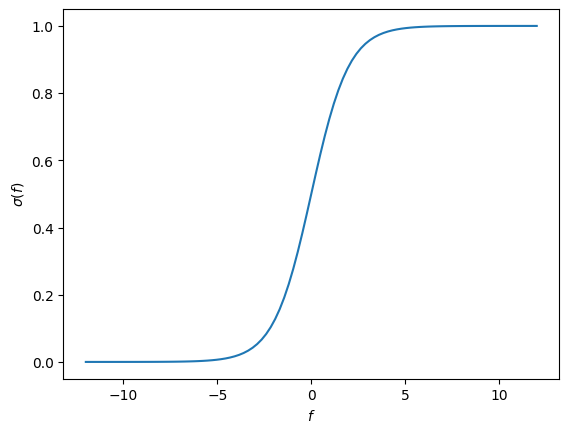

In [ ]:
num_points = 101
f = torch.linspace(-12, 12, num_points)
# sigma = lambda f: 1 / (1 + np.exp(-f))
# sigma = torch.sigmoid(f)
# plt.plot(f, sigma(f));
plt.plot(f, torch.sigmoid(f));
# plt.plot(f, sigma);
plt.ylabel('$\sigma(f)$');
plt.xlabel('$f$');

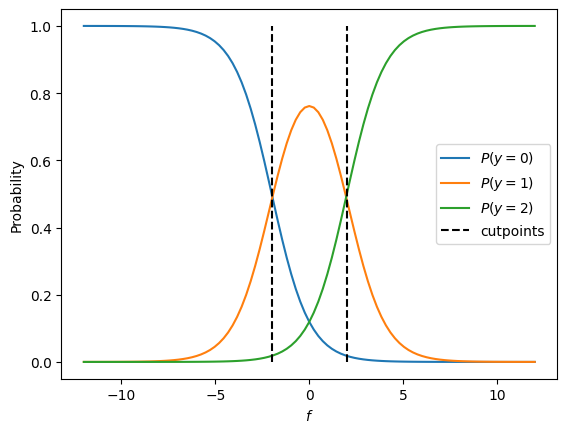

In [ ]:
def plot_ordinal_classes(f, cutpoints):
    num_classes = len(cutpoints) + 1
    labels = []
    for idx in range(num_classes):
        if idx == 0:
            plt.plot(f, torch.sigmoid(cutpoints[0] - f));
        elif idx == num_classes - 1:
            plt.plot(f, 1 - torch.sigmoid(cutpoints[-1] - f));
        else:
            plt.plot(f, torch.sigmoid(cutpoints[idx] - f) - torch.sigmoid(cutpoints[idx - 1] - f));
        labels.append(f'$P(y = {idx})$')
    for c in cutpoints:
        plt.plot((c, c), (0, 1), 'k--')
    labels.append('cutpoints')
    plt.legend(labels);
    plt.ylabel('Probability');
    plt.xlabel('$f$');

cutpoints = [-2, 2]
plot_ordinal_classes(f, cutpoints)

# Logistic likelihood
# plt.plot(f, torch.sigmoid((cutpoints[idx] - f)/sigma) - torch.sigmoid((cutpoints[idx - 1] - f)/sigma));



In [ ]:
# @title from spacecutter

# https://github.com/EthanRosenthal/spacecutter/blob/master/spacecutter/models.py
from copy import deepcopy
import torch
from torch import nn

class LogisticCumulativeLink(nn.Module):
    """
    Converts a single number to the proportional odds of belonging to a class.

    Parameters
    ----------
    num_classes : int
        Number of ordered classes to partition the odds into.
    init_cutpoints : str (default='ordered')
        How to initialize the cutpoints of the model. Valid values are
        - ordered : cutpoints are initialized to halfway between each class.
        - random : cutpoints are initialized with random values.
    """

    def __init__(self, num_classes, init_cutpoints = 'ordered'):
        assert num_classes > 2, ('Only use this model if you have 3 or more classes')
        super().__init__()
        self.num_classes = num_classes
        self.init_cutpoints = init_cutpoints
        if init_cutpoints == 'ordered':
            num_cutpoints = self.num_classes - 1
            cutpoints = torch.arange(num_cutpoints).float() - num_cutpoints / 2
            self.cutpoints = nn.Parameter(cutpoints)
        elif init_cutpoints == 'random':
            cutpoints = torch.rand(self.num_classes - 1).sort()[0]
            self.cutpoints = nn.Parameter(cutpoints)

    def forward(self, X):
        # Equation (11) from "On the consistency of ordinal regression methods", Pedregosa et. al.
        sigmoids = torch.sigmoid(self.cutpoints - X)
        link_mat = sigmoids[:, 1:] - sigmoids[:, :-1]
        link_mat = torch.cat((sigmoids[:, [0]], link_mat, (1 - sigmoids[:, [-1]])), dim=1)
        return link_mat


class OrdinalLogisticModel(nn.Module):
    """
    "Wrapper" model for outputting proportional odds of ordinal classes.
    Pass in any model that outputs a single prediction value, and this module
    will then pass that model through the LogisticCumulativeLink module.

    Parameters
    ----------
    predictor : nn.Module
        When called, must return a torch.FloatTensor with shape [batch_size, 1]
    init_cutpoints : str (default='ordered')
        How to initialize the cutpoints of the model. Valid values are
        - ordered : cutpoints are initialized to halfway between each class.
        - random : cutpoints are initialized with random values.
    """

    def __init__(self, predictor, num_classes, init_cutpoints = 'ordered'):
        super().__init__()
        self.num_classes = num_classes
        self.predictor = deepcopy(predictor)
        self.link = LogisticCumulativeLink(self.num_classes, init_cutpoints=init_cutpoints)

    def forward(self, *args, **kwargs):
        return self.link(self.predictor(*args, **kwargs))



# https://github.com/EthanRosenthal/spacecutter/blob/master/spacecutter/losses.py
import numpy as np
import torch
from torch import nn
from typing import Optional


def _reduction(loss, reduction):
    """loss : [batch_size, num_classes] Batch losses.
    reduction : Method for reducing the loss. 'elementwise_mean', 'none', and 'sum'. """
    if reduction == 'elementwise_mean':
        return loss.mean()
    elif reduction == 'none':
        return loss
    elif reduction == 'sum':
        return loss.sum()

def cumulative_link_loss(y_pred, y_true, reduction = 'elementwise_mean', class_weights = None):
    """Calculates the negative log likelihood using the logistic cumulative link function.
    "On the consistency of ordinal regression methods", Pedregosa et. al.
    y_pred [batch_size, num_classes]; y_true [batch_size, 1]
        True target classes. long dtype.
    reduction : Method for reducing the loss. 'elementwise_mean', 'none', and 'sum'.
    class_weights : multiply that sample's loss by the weight in this array."""
    eps = 1e-15
    likelihoods = torch.clamp(torch.gather(y_pred, 1, y_true), eps, 1 - eps)
    neg_log_likelihood = -torch.log(likelihoods)
    if class_weights is not None:
        # Make sure it's on the same device as neg_log_likelihood
        class_weights = torch.as_tensor(class_weights, dtype=neg_log_likelihood.dtype, device=neg_log_likelihood.device)
        neg_log_likelihood *= class_weights[y_true]
    loss = _reduction(neg_log_likelihood, reduction)
    return loss


class CumulativeLinkLoss(nn.Module):
    """Module form of cumulative_link_loss() loss function
    reduction : str
        Method for reducing the loss. Options include 'elementwise_mean', 'none', and 'sum'.
    class_weights : np.ndarray, [num_classes] optional (default=None)
        An array of weights for each class. If included, then for each sample, look up the true class and multiply that sample's loss by the weight in this array."""
    def __init__(self, reduction = 'elementwise_mean', class_weights = None):
        super().__init__()
        self.class_weights = class_weights
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        return cumulative_link_loss(y_pred, y_true, reduction=self.reduction, class_weights=self.class_weights)


In [ ]:
# @title from condor
# https://github.com/GarrettJenkinson/condor_pytorch

# https://github.com/GarrettJenkinson/condor_pytorch/blob/main/src/condor_pytorch/dataset.py
import torch

def label_to_levels(label, num_classes, dtype=torch.float32):
    if not label <= num_classes-1:
        raise ValueError('Class label must be smaller or equal to %d (num_classes-1). Got %d.' % (num_classes-1, label))
    if isinstance(label, torch.Tensor):
        int_label = label.item()
    else:
        int_label = label
    levels = [1]*int_label + [0]*(num_classes - 1 - int_label)
    levels = torch.tensor(levels, dtype=dtype, device=label.device)
    return levels


def levels_from_labelbatch(labels, num_classes, dtype=torch.float32):
    """shape=(num_labels, num_classes-1)
    >>> levels_from_labelbatch(labels=[2, 1, 4], num_classes=5)
    tensor([[1., 1., 0., 0.],
            [1., 0., 0., 0.],
            [1., 1., 1., 1.]])"""
    levels = []
    for label in labels:
        levels_from_label = label_to_levels(label=label, num_classes=num_classes, dtype=dtype)
        levels.append(levels_from_label)
    levels = torch.stack(levels)
    return levels

def logits_to_label(logits):
    probas = torch.cumprod(torch.sigmoid(logits), dim=1)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    return predicted_labels


# https://github.com/GarrettJenkinson/condor_pytorch/blob/main/src/condor_pytorch/losses.py
import torch.nn.functional as F
import torch

# Modifed from: https://github.com/tensorflow/tensorflow/blob/6dcd6fcea73ad613e78039bd1f696c35e63abb32/tensorflow/python/ops/nn_impl.py#L112-L148
def condor_negloglikeloss(logits, labels, reduction='mean'):
    if not logits.shape == labels.shape:
        raise ValueError("Please ensure that logits (%s) has the same shape as labels (%s). " % (logits.shape, labels.shape))
    piLab = torch.cat([torch.ones((labels.shape[0],1), device=labels.device),labels[:,:-1]],dim=1)

    # The logistic loss formula from above is
    #   x - x * z + log(1 + exp(-x))
    # For x < 0, a more numerically stable formula is
    #   -x * z + log(1 + exp(x))
    # Note that these two expressions can be combined into the following:
    #   max(x, 0) - x * z + log(1 + exp(-abs(x)))
    # To allow computing gradients at zero, we define custom versions of max and abs functions.
    zeros = torch.zeros_like(logits, dtype=logits.dtype, device=logits.device)
    cond = (logits >= zeros)
    cond2 = (piLab > zeros)
    relu_logits = torch.where(cond, logits, zeros)
    neg_abs_logits = torch.where(cond, -logits, logits)
    temp = relu_logits - (logits*labels) + torch.log1p(torch.exp(neg_abs_logits))
    val = torch.sum(torch.where(cond2, temp, zeros),dim=1)

    if reduction == 'mean':
        loss = torch.mean(val)
    elif reduction == 'sum':
        loss = torch.sum(val)
    elif reduction is None:
        loss = val
    return loss

def CondorOrdinalCrossEntropy(logits, levels, importance_weights=None, reduction='mean'):
    if not logits.shape == levels.shape:
        raise ValueError("Please ensure that logits (%s) has the same shape as levels (%s). " % (logits.shape, levels.shape))
    logprobs = torch.cumsum(F.logsigmoid(logits), dim = 1)
    term1 = (logprobs*levels + torch.log(1 - torch.exp(logprobs)+torch.finfo(torch.float32).eps)*(1-levels))
    if importance_weights is not None:
        term1 *= importance_weights
    val = (-torch.sum(term1, dim=1))
    if reduction == 'mean':
        loss = torch.mean(val)
    elif reduction == 'sum':
        loss = torch.sum(val)
    elif reduction is None:
        loss = val
    return loss


# https://github.com/GarrettJenkinson/condor_pytorch/blob/main/src/condor_pytorch/activations.py
import torch
import torch.nn.functional as F

def ordinal_softmax(x, device='cpu'):
    """ x: torch.Tensor, shape=(num_samples,num_classes-1) Logit output of the final Dense(num_classes-1) layer.
    probs_tensor: torch.Tensor, shape=(num_samples, num_classes) Probabilities of each class (columns) for each sample (rows).
    >>> ordinal_softmax(torch.tensor([[-1.,1],[-2,2]]))
    tensor([[0.7311, 0.0723, 0.1966],
            [0.8808, 0.0142, 0.1050]])"""
    # Convert the ordinal logits into cumulative probabilities.
    log_probs = F.logsigmoid(x).to(device)
    cum_probs = torch.cat((torch.ones(x.shape[0],1,dtype=torch.float32).to(device),
        torch.exp(torch.cumsum(log_probs, dim = 1)), torch.zeros(x.shape[0],1,dtype=torch.float32).to(device)), dim=1)    
    return cum_probs[:,0:-1] - cum_probs[:,1:]


# https://github.com/GarrettJenkinson/condor_pytorch/blob/main/src/condor_pytorch/metrics.py
import torch.nn.functional as F
import torch
# from .activations import ordinal_softmax

def earth_movers_distance(logits, levels, device='cpu', reduction='mean'):
    nclasses = logits.shape[1]+1
    nbatch = logits.shape[0]
    if not logits.shape == levels.shape: raise ValueError("Please ensure that logits (%s) has the same shape as levels (%s). " % (logits.shape, levels.shape))
    cum_probs = ordinal_softmax(logits, device)
    y_true = torch.sum(levels,dim=1,keepdim=True,dtype=logits.dtype)
    # y_dist = torch.abs(torch.tile(y_true,(1,nclasses)) -torch.tile(torch.arange(0,nclasses),(nbatch,1)))
    y_dist = torch.abs(y_true.repeat(1,nclasses) - torch.arange(0,nclasses).repeat(nbatch,1)).to(device)
    val = torch.sum(torch.mul(cum_probs,y_dist),1)
    if reduction == 'mean':
        loss = torch.mean(val)
    elif reduction == 'sum':
        loss = torch.sum(val)
    elif reduction is None:
        loss = val
    return loss

def ordinal_accuracy(logits, levels, device='cpu', tolerance=0, reduction='mean'):
    """tolerance : Allowed error in the ordinal ranks that will count as a correct prediction."""
    nclasses = logits.shape[1]+1
    nbatch = logits.shape[0]
    if not logits.shape == levels.shape:
        raise ValueError("Please ensure that logits (%s) has the same shape as levels (%s). " % (logits.shape, levels.shape))
    y_true = torch.sum(levels,dim=1,keepdim=True,dtype=logits.dtype).to(device)
    y_est = torch.sum(torch.cumprod(torch.sigmoid(logits),dim=1)>0.5,dim=1,keepdim=True,dtype=logits.dtype).to(device)
    # 1 when correct and 0 else
    val = torch.le(torch.abs(y_true-y_est),tolerance).to(torch.float32)
    if reduction == 'mean':
        loss = torch.mean(val)
    elif reduction == 'sum':
        loss = torch.sum(val)
    elif reduction is None:
        loss = val
    return loss

def mean_absolute_error(logits, levels, reduction='mean'):
    nclasses = logits.shape[1]+1
    nbatch = logits.shape[0]
    if not logits.shape == levels.shape:
        raise ValueError("Please ensure that logits (%s) has the same shape as levels (%s). " % (logits.shape, levels.shape))
    y_true = torch.sum(levels,dim=1,keepdim=True,dtype=logits.dtype)
    y_est = torch.sum(torch.cumprod(torch.sigmoid(logits),dim=1)>0.5,dim=1,keepdim=True,dtype=logits.dtype)
    # 1 when correct and 0 else
    val = torch.abs(y_true-y_est)
    if reduction == 'mean':
        loss = torch.mean(val)
    elif reduction == 'sum':
        loss = torch.sum(val)
    elif reduction is None:
        loss = val
    return loss



In [ ]:
# @title try

# # check model's input and output dimensions are correct
# X = torch.rand(64, 3, 32, 32, device=device)
X = torch.rand(16, 3, 400, 640, device=device)
# X = torch.rand(16, 3, 224, 224, device=device)
model.eval()

# 224x224
# 16x16 / 32x32 patch
# -> 14x14=196 7x7=49 seq length
# 400x640 -> 25x40=1000 seq length


logits = model(X)

# modules = [module for k, module in model._modules.items()]
# for i,x in enumerate(modules):
#     print(i,x)

# logits = checkpoint_sequential(functions=modules, segments=1, input=X)

# print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))

# # pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = logits_to_label(logits)
# print(y_pred)
# pred_probab = ordinal_softmax(logits)
# y_pred = pred_probab.argmax(1)
# print(y_pred)

acc=0.
correct=0
y = torch.randint(0,6,(16,), device=device)
print(y)

levels = levels_from_labelbatch(y, num_classes=6) # condor
print(levels)
logits = model(X)
print(logits)
# mae  += mean_absolute_error(logits,levels,reduction='sum')
acc += ordinal_accuracy(logits,levels,tolerance=0,reduction='sum')
# acc1 += ordinal_accuracy(logits,levels,tolerance=1,reduction='sum')
# emd  += earth_movers_distance(logits,levels,reduction='sum')
predicted_labels = logits_to_label(logits).float()
print(predicted_labels)
correct += (predicted_labels == y).type(torch.float).sum().item()

print(acc)
print(correct)
loss = condor_negloglikeloss(logits, levels)
print(loss)


tensor([0, 5, 3, 0, 1, 3, 3, 1, 4, 1, 4, 0, 5, 1, 5, 2], device='cuda:0')
tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0.]], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor(3.)
3.0
tensor(2.3307, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            pred = model(sx) # default

            # pred = model(sx)[0] # inception

            # modules = [module for k, module in model._modules.items()]
            # pred = checkpoint_sequential(functions=modules, segments=1, input=sx) # gradient checkpointing for resnet and inception only
            # # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=sx)

            # loss = loss_fn(pred, sy) # /4 to scale by gradient accumulation_steps

            levels = levels_from_labelbatch(sy, 6) # condor
            loss = condor_negloglikeloss(pred, levels)

        scaler.scale(loss).backward()
        # if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        emd, mae, acc, acc1, num_examples = 0., 0., 0., 0., 0
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            # pred = model(x)
            # loss = loss_fn(pred, y)
            # # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            # test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            logits = model(x)
            levels = levels_from_labelbatch(y, num_classes=6)
            # mae  += mean_absolute_error(logits,levels,reduction='sum')
            # acc += ordinal_accuracy(logits,levels,tolerance=0,reduction='sum')
            # acc1 += ordinal_accuracy(logits,levels,tolerance=1,reduction='sum')
            # emd  += earth_movers_distance(logits,levels,reduction='sum')
            test_loss = condor_negloglikeloss(logits, levels)
            predicted_labels = logits_to_label(logits).float()
            correct += (predicted_labels == y).type(torch.float).sum().item()

            # cum_probs = ordinal_softmax(logits)
            
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


In [ ]:
pth='/content/lr.pth'
torch.save(model.state_dict(), pth) # save temporary model for lr finding


In [ ]:
# @title LR range test
# 1cycle super convergencehttps://arxiv.org/pdf/1708.07120.pdf
# # cyclic lr https://arxiv.org/pdf/1506.01186.pdf
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# one training run of the network for a few epochs

epochs=5
min_lr= 1e-6
max_lr= 1e-2 # 1e-2
# 152: 1e-7 - 1e-4      result 3e-7 - 3e-6

loss_fn = nn.CrossEntropyLoss()
model.load_state_dict(torch.load("lr.pth"))
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), optim_bits=8)

# num_batches=int(np.ceil(len(test_loader)/batch_size))
num_batches=len(test_loader)

# total_steps=int(np.ceil(num_batches/4)*epochs)
total_steps=int(num_batches*epochs)

# min_lr* gamma^total_steps = max_lr
gamma = np.exp(np.log(max_lr/min_lr)/total_steps) # for scheduler step every optimizer step
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)
train_lst, test_lst=[],[]
lr_list=np.ones(total_steps)*min_lr*gamma**np.arange(total_steps)
# gamma = np.exp(np.log(max_lr/min_lr)/(total_steps*4)) # total_steps*4 bec grad accumulation, loss step 4x per lr step
# lr_list=np.ones(total_steps*4)*min_lr*gamma**np.arange(total_steps*4)


for i in range(epochs):
    train_ls = strain(test_loader, model, loss_fn, optimizer, scheduler)    
    train_lst.extend(train_ls)


# https://stackoverflow.com/a/53472966/13359815
from scipy.ndimage.filters import gaussian_filter1d
train_lstsm = gaussian_filter1d(train_lst, sigma=30)

import matplotlib.pyplot as plt
plt.plot(lr_list, train_lst)
plt.plot(lr_list, train_lstsm)
plt.xscale('log')
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()


In [ ]:
# @title wwwwwwwww
import time
# start = time.time()
acc_lst, train_lst, test_lst=[],[],[]
loss_fn = nn.CrossEntropyLoss()


base_lr, max_lr = 3e-6, 3e-5 # 1e-5, 1e-3 #0.5#
# res152 3e-7, 3e-6
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

# print(num_batches)
epochs = 5 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
# gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)
# optimizer = bnb.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), optim_bits=8)
# 152 1e-5
# cnn 3e-4
num_batches=len(train_loader)

div_factor = max_lr/base_lr
# total_steps=int(np.ceil(num_batches/4)*epochs +1) # +1 to excluse uptick at the end of onecycle
total_steps=int(num_batches*epochs +1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=100.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)



# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     lr=optimizer.param_groups[0]["lr"]
#     print(lr)
#     train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
#     # train_ls = strain(train_loader, model, loss_fn, optimizer)
#     correct, test_loss = test(test_loader, model, loss_fn)
#     # scheduler.step()
#     train_lst.extend(train_ls)
#     test_lst.append(test_loss)
#     acc_lst.append(correct)

#     checkpoint = { # https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030
#     'epoch': t,
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
#     'lr_sched': scheduler}
#     # torch.save(checkpoint, 'checkpoint.pth')
#     torch.save(checkpoint, '/content/drive/MyDrive/frame/resnet152.pth')

# print("Done!")

# end = time.time()
# print("time: ",end - start)

# print(len(train_lst), len(test_lst))
# import matplotlib.pyplot as plt
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
# plt.show()
# plt.plot(acc_lst)
# plt.show()
# plt.close()


# torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# resnet 18, 60/61 38.4%, 528s
# resnet 18, 58/61 39.8%, 523s
# resnet 18 compile , 58/61 40.4%, 555s
# resnet 18 compile augment , 58/61 36.4%, 1941 # augment on cpu, takes longer
# resnet 18 augment lr3e-4:3e-3, 58/61 37.7%, 1863s
# resnet 18 augment 10epoch lr1e-5:3e-4, 58/61 33.5%, 3387s
# resnet 18 compile lr1e-5:3e-4, 58/61 35.0%, 493s
# resnet 18 compile scratch lr1e-5:1e-3, 58/61 26.8%, 475s
# resnet 18 compile lr1e-5:1e-3, 55/61 47.3%, 480s
# resnet 18 compile lr1e-5:1e-3, 52/61 51.7% 503s
# resnet 18 compile lr1e-5:1e-3, unfreeze 51.0%, 550s
# resnet 18 compile lr1e-5:1e-4, unfreeze 52.7%, 518s
# resnet 34 compile lr1e-5:1e-4, unfreeze bitsadamW batch16*4
# resnet 152 compileoverhead lr3e-7:3e-6, bitsadamW batch16*4 ckpt 53.8%, 2066s
# resnet 152 from53.8% augment+cutout lr3e-7:3e-6, 53.8%, 2088s
# resnet 152 comile augment+cutout lr1e-5 /4 1epoch 48.3%, 454s
# resnet 152 comile augment+cutout lr1e-5 1epoch 48.4%, 446s
# resnet 152 comilemaxautotue augment+cutout lr1e-5 1epoch 47.7%, 448
# resnet 152 clipclean comilemax augment+cutout lr1e-5 10epoch 45.1%, 1585 *2
# resnet 152 clipclean comilemax augmax lr1e-6:3e-5 20epoch 
# resnet 152 clipclean compilemax lr3e-7:1e-5,  
# resnet 152 70k augment compilemax lr3e-7:3e-6 5epoch, 65.4% 11585s*5/3=19300s = 5h20m


# vit b16 lr1e-5 5epochs 41.3%, 466s # 4.4ram, 5.5vram
# vit l16 lr1e-5 5epochs # 32.0%, 1242s 4.5ram, 8.0vram
# vit l16 lr3e-7;1e-5 5epochs # 45.4%, 1315s 4.5ram, 8.0vram
# vit l32 lr1e-5 5epochs # .ram, .vram
# vit_large_patch16_384
# vit_base_patch16_224 maxcompile nockpt lr3e-7;1e-5 5epochs # 45.2%, 2272s 5.3ram, 11.0vram

# inception


# ordinal regression
# res18 condor 10k compile 3e-6;3e-5 5epochs 50.5%, 558s




In [ ]:
for x in range(983):
    scheduler.step()
    # print(x)
# 4916
# 4915/5 = 983
# 2321


In [ ]:
import time
start = time.time()


for t in range(0,epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # train_ls = strain(train_loader, model, loss_fn, optimizer)
    correct, test_loss = test(test_loader, model, loss_fn)
    # scheduler.step()
    train_lst.extend(train_ls)
    test_lst.append(test_loss)
    acc_lst.append(correct)

    # checkpoint = { # https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030
    # 'epoch': t,
    # 'model': model.state_dict(),
    # 'optimizer': optimizer.state_dict(),
    # 'lr_sched': scheduler}
    # # torch.save(checkpoint, 'checkpoint.pth')
    # torch.save(checkpoint, '/content/drive/MyDrive/frame/resnet1522.pth')

print("Done!")

end = time.time()
print("time: ",end - start)



Epoch 1
-------------------------------
3.0000000000000018e-06


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-05-26 07:31:35,792] torch._inductor.utils: [WARNING] not enough cuda cores to use max_autotune mode


loss: 2.404927 [    0/ 7421]
loss: 1.865681 [  736/ 7421]
loss: 2.055575 [ 1472/ 7421]
loss: 1.492023 [ 2208/ 7421]
loss: 1.782691 [ 2944/ 7421]
loss: 1.426641 [ 3680/ 7421]
loss: 1.559449 [ 4416/ 7421]
loss: 1.416460 [ 5152/ 7421]
loss: 1.183061 [ 5888/ 7421]
loss: 1.253870 [ 6624/ 7421]
loss: 0.998616 [ 7360/ 7421]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-05-26 07:34:32,754] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation
[2023-05-26 07:34:47,187] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation


Accuracy: 45.7%, Avg loss: 0.022385
Epoch 2
-------------------------------
1.416553484792832e-05


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 1.109751 [    0/ 7421]
loss: 1.383150 [  736/ 7421]
loss: 0.923082 [ 1472/ 7421]
loss: 1.137920 [ 2208/ 7421]
loss: 1.051536 [ 2944/ 7421]
loss: 0.871880 [ 3680/ 7421]
loss: 0.895865 [ 4416/ 7421]
loss: 1.586850 [ 5152/ 7421]
loss: 1.016021 [ 5888/ 7421]
loss: 1.023011 [ 6624/ 7421]
loss: 1.487060 [ 7360/ 7421]
Accuracy: 35.4%, Avg loss: 0.028859
Epoch 3
-------------------------------
2.919263295611303e-05
loss: 1.443429 [    0/ 7421]
loss: 1.042650 [  736/ 7421]
loss: 1.314538 [ 1472/ 7421]
loss: 1.535051 [ 2208/ 7421]
loss: 0.991212 [ 2944/ 7421]
loss: 0.791767 [ 3680/ 7421]
loss: 1.103047 [ 4416/ 7421]
loss: 0.973236 [ 5152/ 7421]
loss: 1.208249 [ 5888/ 7421]
loss: 1.486366 [ 6624/ 7421]
loss: 0.983484 [ 7360/ 7421]
Accuracy: 45.3%, Avg loss: 0.014389
Epoch 4
-------------------------------
2.3224170237120936e-05
loss: 0.884194 [    0/ 7421]
loss: 0.625498 [  736/ 7421]
loss: 1.016064 [ 1472/ 7421]
loss: 0.833500 [ 2208/ 7421]
loss: 0.518749 [ 2944/ 7421]
loss: 0.609870 [ 368

In [ ]:
correct, test_loss = test(test_loader, model, loss_fn)


Accuracy: 48.1%, Avg loss: 0.028525


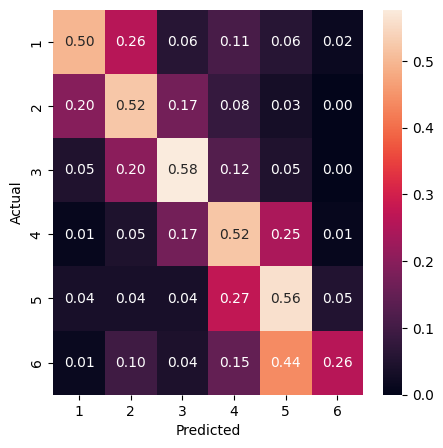

In [ ]:
# @title confusion matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

model.eval()
test_loss, correct = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    emd, mae, acc, acc1, num_examples = 0., 0., 0., 0., 0
    for X, y in test_loader:
        x, y = X.to(device), y.to(device)
        # pred = model(x)
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        logits = model(x)
        predicted_labels = logits_to_label(logits).float()
        y_true.extend(list(y.cpu()))
        y_pred.extend(list(predicted_labels.cpu()))

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['1','2','3','4','5','6',], yticklabels=['1','2','3','4','5','6',])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [ ]:
# @title save

from google.colab import drive
drive.mount('/content/drive')

# # pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/res55.pth'
pth='/content/drive/MyDrive/frame/resnet152.pth'

torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load(pth))
# # model.load_state_dict(torch.load("model.pth"))





# # https://drive.google.com/file/d/1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv/view?usp=share_link
# !gdown 1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv -O resnet152.pth

# # t, modelsd, optimsd, scheduler = torch.load('/content/drive/MyDrive/frame/resnet152.pth').values()
# t, modelsd, optimsd, scheduler = torch.load('/content/resnet152.pth').values()
# model.load_state_dict(modelsd)
# # optimizer.load_state_dict(optimsd)



# # matt152 # https://drive.google.com/file/d/1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J/view?usp=sharing
# !gdown 1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J -O res152.pth
# model.load_state_dict(torch.load("res152.pth"))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


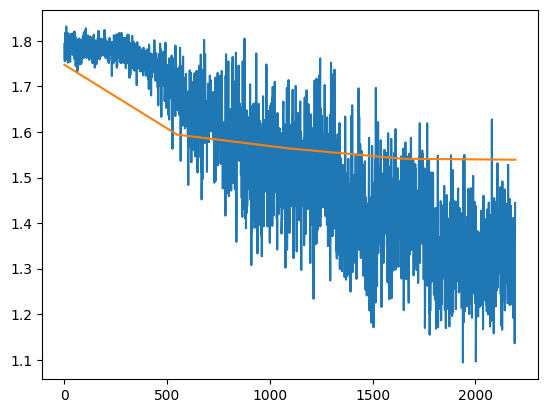

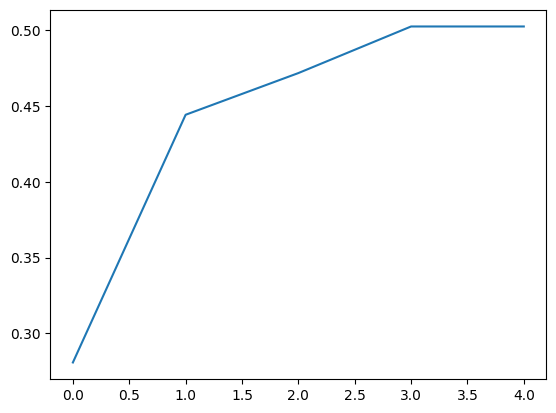

In [ ]:
# correct, test_loss = test(test_loader, model, loss_fn)


plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()

In [ ]:
# dir='/content/google_street_view'

# # data = datasets.ImageFolder(dir, transform=transform)
# data = datasets.ImageFolder(dir, transform=None)
# torch.manual_seed(0)
# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])

# # train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
# train_data = DatasetWrap(train_data, transform)
# test_data = DatasetWrap(test_data, transform)


# batch_size = 16 # 64
# num_batches=int(np.ceil(len(train_data)/batch_size))

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
# # data, train_data, test_data = None, None, None


# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images))
# dataiter=None


%matplotlib inline 
from matplotlib import pyplot as plt

# dataiter = iter(train_data)


# img,label = next(iter(sample_ds))
i=5
# print(len(test_data))
# img,label=test_data[i]
img,label=sample_ds[i]
print(img.shape)
# print(type(img))
model.eval()
pred=model(img.unsqueeze(0).to(device))
pred_probab = nn.Softmax(dim=1)(pred)
y_pred = pred_probab.argmax(1)
print(pred_probab)
print("pred: ",y_pred.item())
# print(img)
# image=images[0]

print("actual: ",label)
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()


In [ ]:

model.eval()
count=0
i=138
rong_lst=[]

while count<20:
    img,label=test_data[i]
    pred=model(img.unsqueeze(0).to(device))
    pred_probab = nn.Softmax(dim=1)(pred)
    y_pred = pred_probab.argmax(1)
    if y_pred.item() != label:
        print("pred: ",y_pred.item(),", actual: ",label)
        # plt.imshow(np.transpose(img, (1, 2, 0)))
        # plt.show()
        imshow(img)
        rong_lst.append(img)
        count+=1
    i+=1


# 20/137 wrong


In [ ]:
print(i)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# print(torch.stack(rong_lst).shape)
# print(len(rong_lst))
# print(rong_lst[0].shape)
imshow(torchvision.utils.make_grid(torch.stack(rong_lst),nrow=4))
